# Data Visualisation Assignment
Using a data set on earthquakes taken from USGS (U.S Geological Survey).

**Temporal Trends**: Explore how earthquake frequency changes over time. Are there seasonal patterns or long-term trends?

**Depth Analysis**: Investigate the depths at which earthquakes occur to gain insights into their origins.

**Magnitude vs. Depth**: Examine the relationship between earthquake magnitude and depth.

**Impact Analysis**: If available, consider data on the impact of earthquakes, such as casualties or economic damage.

**Time-Series Analysis**: Use time-series techniques to study earthquake patterns and predict future seismic activity if applicable.

In [74]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
pd.options.mode.chained_assignment = None

df = pd.read_csv('all_month.csv')

## Basic statistics on the dataset
df.describe()

## Count
# print(df.groupby(["day"]).count())

# tips_by_day = df.groupby('day')['tip'].sum()
# print(tips_by_day.to_frame("tip (£)").reset_index())

# """fig, ax = plt.subplots(1,2)
# df.hist(column="total_bill",ax=ax[0])
# df.hist(column="total_bill",bins=20,ax=ax[1])


,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,9662.000000,9662.000000,9662.000000,9661.000000,7316.000000,7316.000000,5868.000000,9662.000000,6691.000000,9661.000000,7283.000000,7306.000000
mean,40.912697,-116.671667,23.355603,1.565404,22.765856,117.215181,0.595249,0.288808,1.673778,2.099876,0.225285,16.652614
std,18.974728,65.423597,52.890429,1.202643,22.257144,66.359577,2.084116,0.266167,3.799421,4.939657,0.343733,27.449907
min,-65.899300,-179.994000,-3.430000,-1.020000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.991375,-152.311550,2.850000,0.770000,10.000000,68.000000,0.020028,0.100000,0.260000,0.400000,0.111000,6.000000
50%,38.836499,-122.788833,8.180000,1.340000,16.000000,99.000000,0.061570,0.180000,0.440000,0.700000,0.165206,10.000000
75%,57.997700,-116.590667,17.007500,2.000000,28.000000,151.475000,0.173125,0.460000,1.028817,1.530000,0.237541,18.000000
max,79.568100,179.977500,649.778000,7.100000,393.000000,357.000000,35.654000,2.820000,176.932676,87.300000,5.240000,504.000000


### **Geographical Distribution**
Determine where most earthquakes occur, which regions are most affected, and identify earthquake-prone areas.

<Axes: >

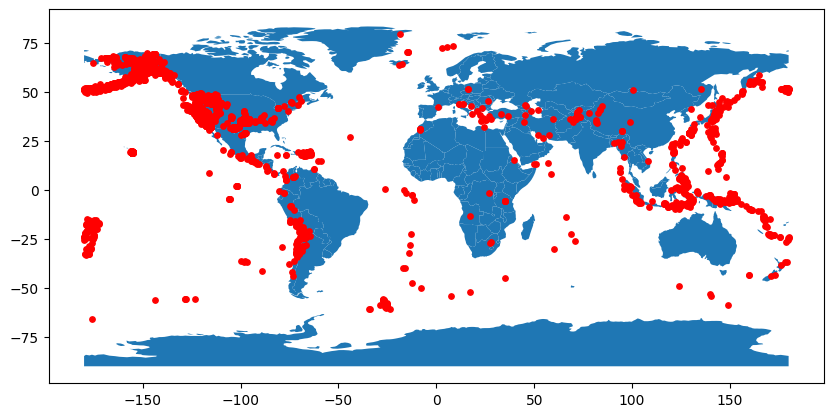

In [63]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

# Simple map that goes w/ geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

### **Magnitude Trends**
Analyze the distribution of earthquake magnitudes to understand the frequency of small, moderate, and large earthquakes.

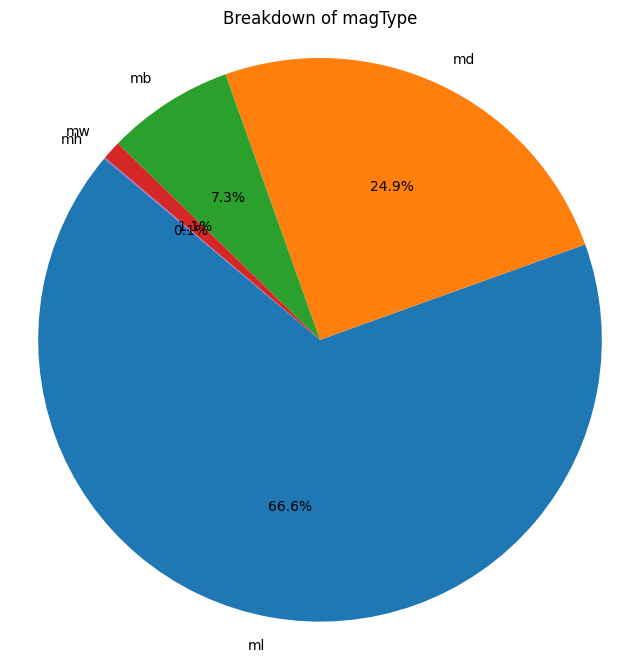

In [93]:
# Group 'magType' values and count their occurrences
grouped_mag_type = df['magType'].replace({"mlv": "ml",
                                           "ml(texnet)": "ml",
                                           "Mb" : "mb",
                                           "mb_lg" : "mb",
                                           "mwr" : "mw",
                                           "mww" : "mw"
                                           }).value_counts()

plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(grouped_mag_type, labels=grouped_mag_type.index, autopct='%1.1f%%', startangle=140)
plt.title("Breakdown of magType")
plt.axis("equal")  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


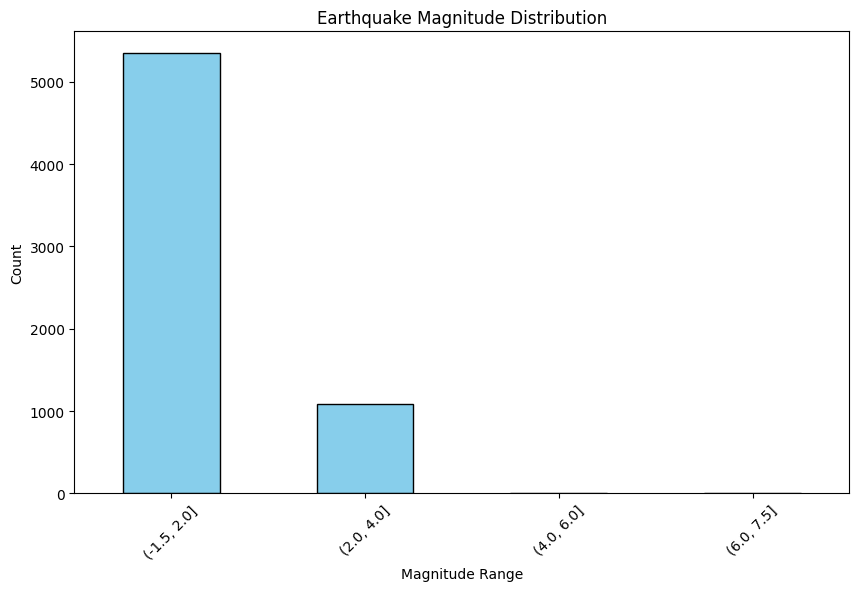

In [96]:
# Define the values you want to filter for
values_to_include = ['ml', 'mlv', 'ml(texnet)']

# Create the subset
subset_df = df[df['magType'].isin(values_to_include)]

# Group data into ranges
ranges = [-1.5, 2, 4, 6, 7.5]
bar_labels = ["unnoticeable", "small vibration", "medium damage", "serious"]

# Use the pandas cut function to categorize the data into bins based on the defined ranges.
subset_df['range_category'] = pd.cut(subset_df['mag'], bins=ranges)

# Group the data by the range categories and count the occurrences in each category.
range_counts = subset_df['range_category'].value_counts()

# Step 3: Create a bar chart
plt.figure(figsize=(10, 6))
range_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Magnitude Range')
plt.ylabel('Count')
plt.title('Earthquake Magnitude Distribution')
plt.xticks(rotation=45)
plt.show()



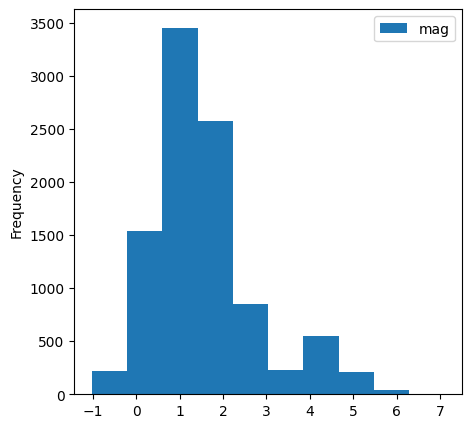

In [34]:
plot = df.plot.hist(y="mag", figsize=(5, 5))

In [85]:
grouped = df.groupby(["magType"])
grouped["mag"].describe()

,count,mean,std,min,25%,50%,75%,max
magType,,,,,,,,
Mb,1.0,4.300000,NaN,4.300000,4.300000,4.300000,4.300000,4.30
mb,687.0,4.468413,0.307213,3.500000,4.300000,4.400000,4.600000,5.70
mb_lg,16.0,2.562500,0.409675,1.800000,2.300000,2.550000,2.800000,3.40
md,2410.0,1.312278,0.845239,-0.760000,0.740000,1.090000,1.840000,4.28
mh,8.0,0.710000,1.097308,-0.500000,0.162500,0.365000,0.825000,2.90
ml,6412.0,1.286523,0.816516,-1.020000,0.740000,1.300000,1.800000,4.70
ml(texnet),20.0,2.207448,0.504647,1.699543,1.900000,2.050000,2.350143,3.90
mlv,3.0,2.557206,0.396206,2.100000,2.435809,2.771618,2.785809,2.80
mw,7.0,3.970000,0.610983,3.250000,3.545000,3.960000,4.250000,4.99
